In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt

import global_params as G
plt.rcParams['figure.figsize'] = G.SMALL_FIG

In [3]:
import numpy as np
from scipy import signal
from scipy.fftpack import fft

np.set_printoptions(precision=4, suppress=True)

In [26]:
from transmitter import *
from receiver import *
from freq_domain import plotspec

## Section 9.1

### Transmitter design

In [6]:
msg = '01234 I wish I were an Oscar Meyer wiener 56789'

<IPython.core.display.Javascript object>


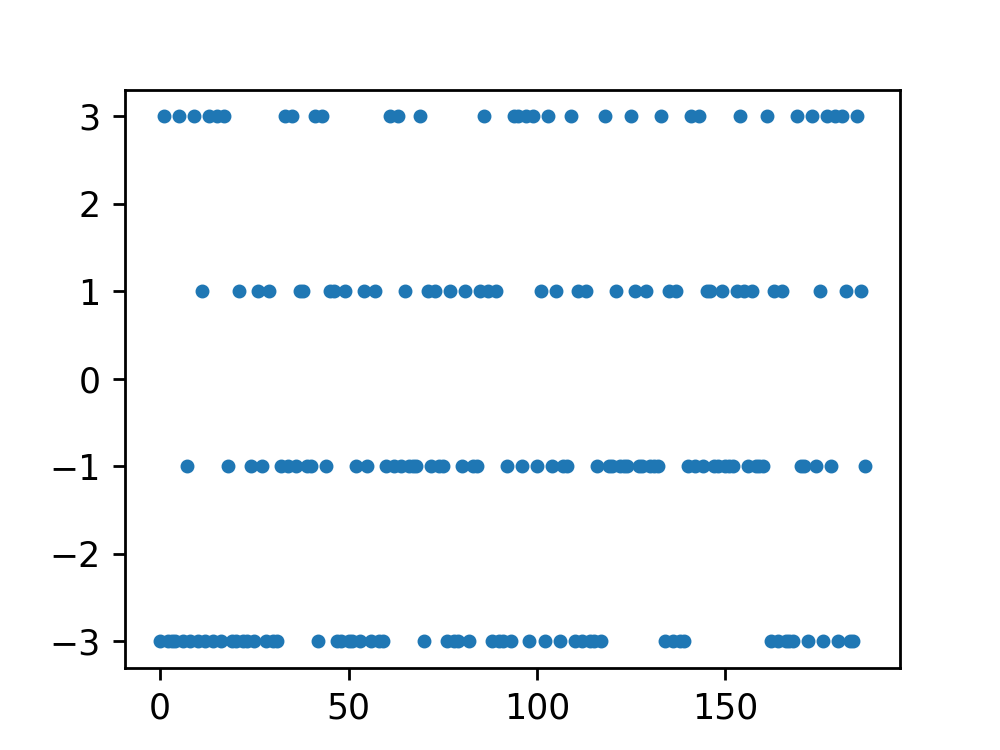

[-3, 3, -3, -3, -3]

In [29]:
# Convert to PAM symbols
symbols = letters2pam(msg)
plt.plot(symbols, '.');
symbols[:5]

<IPython.core.display.Javascript object>


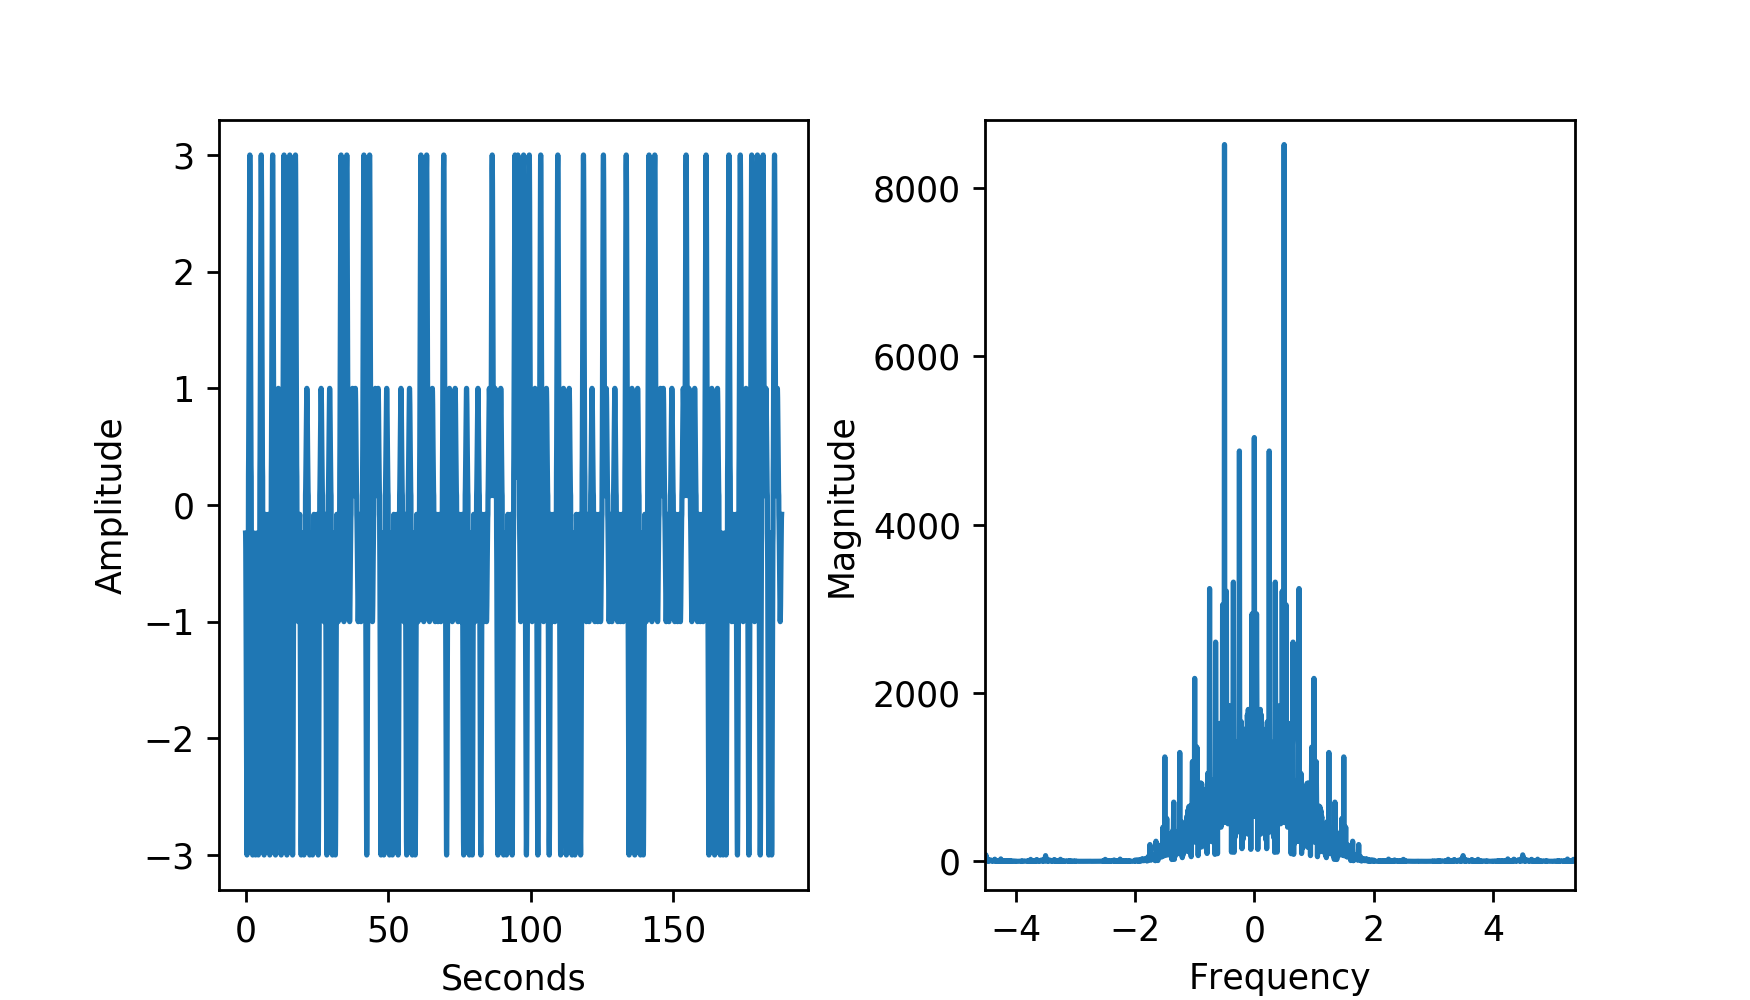

In [15]:
# Pulse shaping with a hamming pulse
M = 100 # oversampling factor
analog_waveform = pulse_shaped(symbols, M)
plotspec(analog_waveform, 1/M);

<IPython.core.display.Javascript object>


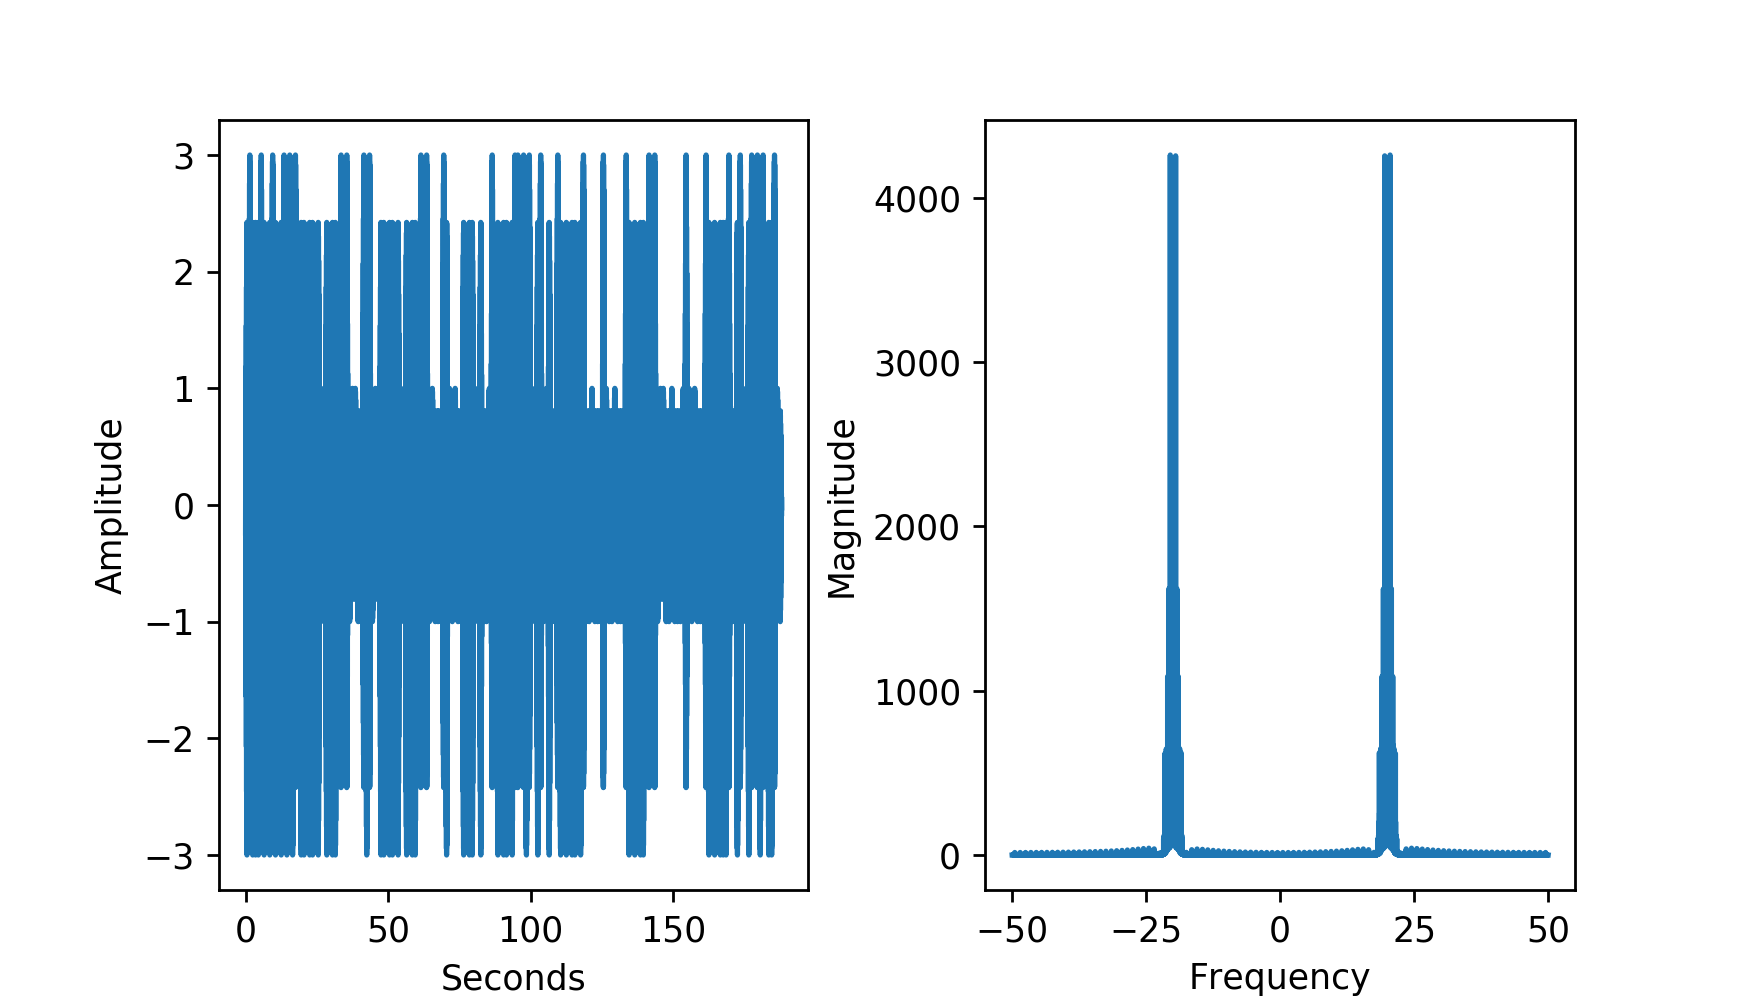

In [16]:
fc = 20
t, transmitted = modulate(analog_waveform, fc, 1/M)
plotspec(transmitted, 1/M);

### Receiver design

<IPython.core.display.Javascript object>


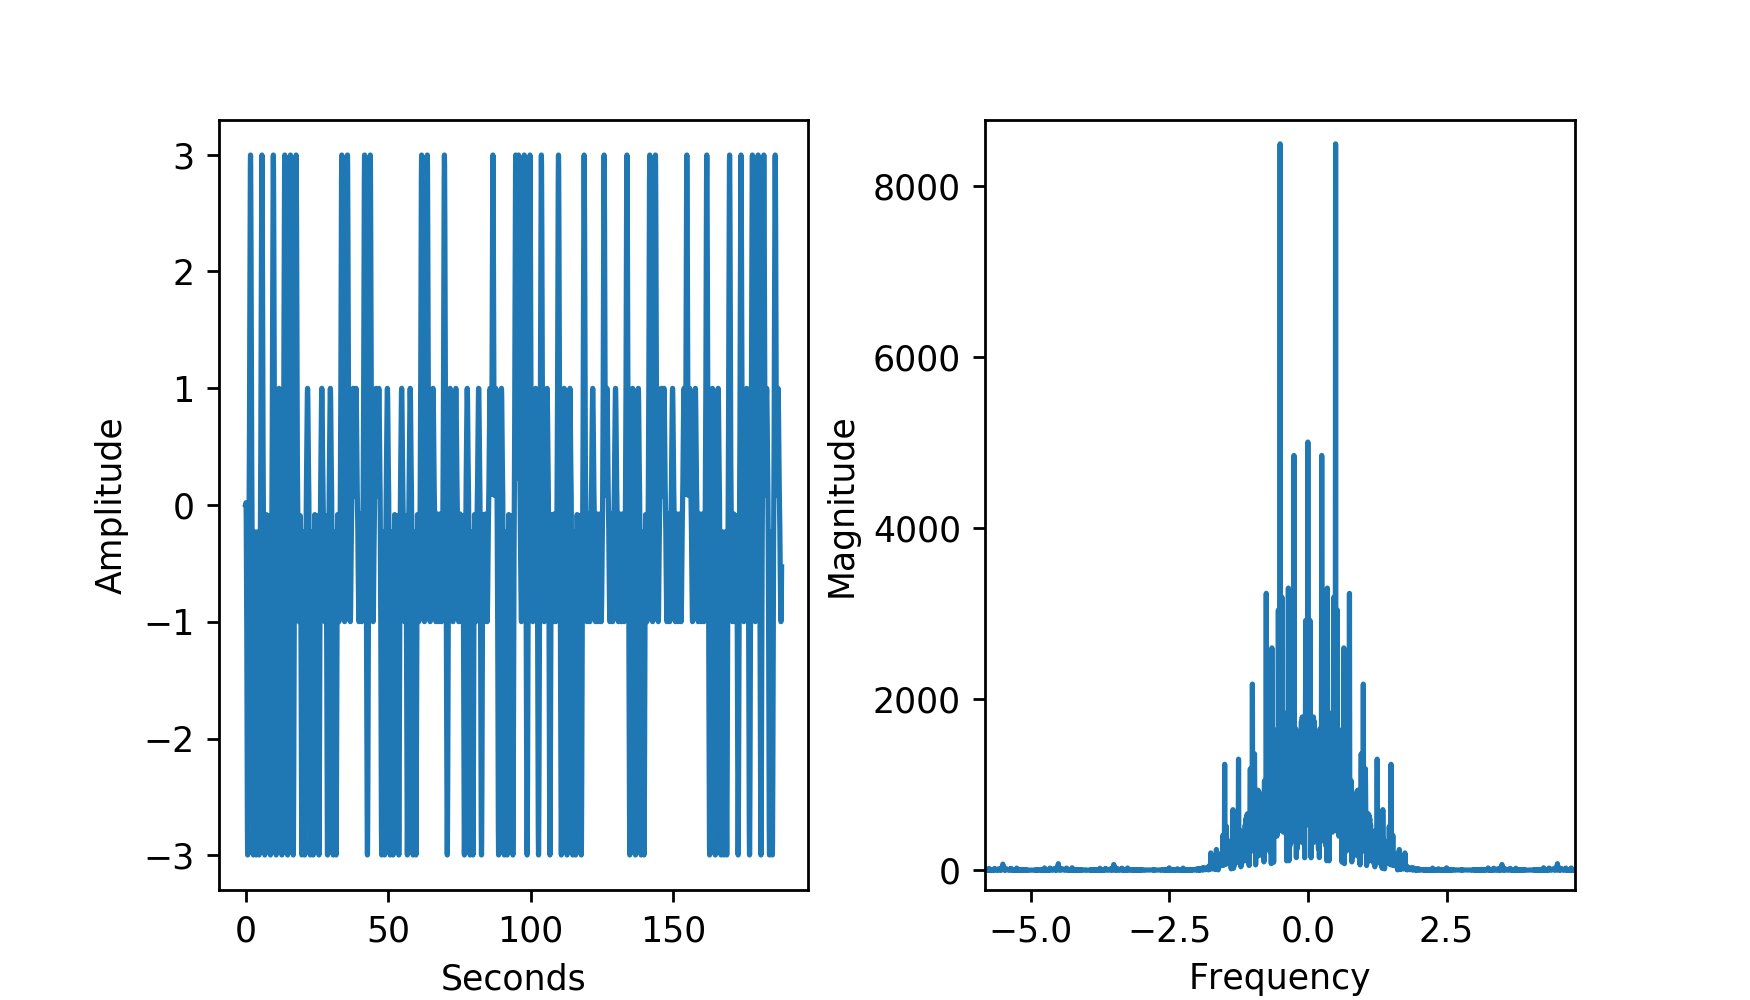

In [25]:
fc = 20
Ts = 1/M
baseband = demodulate(transmitted, fc, Ts)
plotspec(baseband, Ts);

<IPython.core.display.Javascript object>


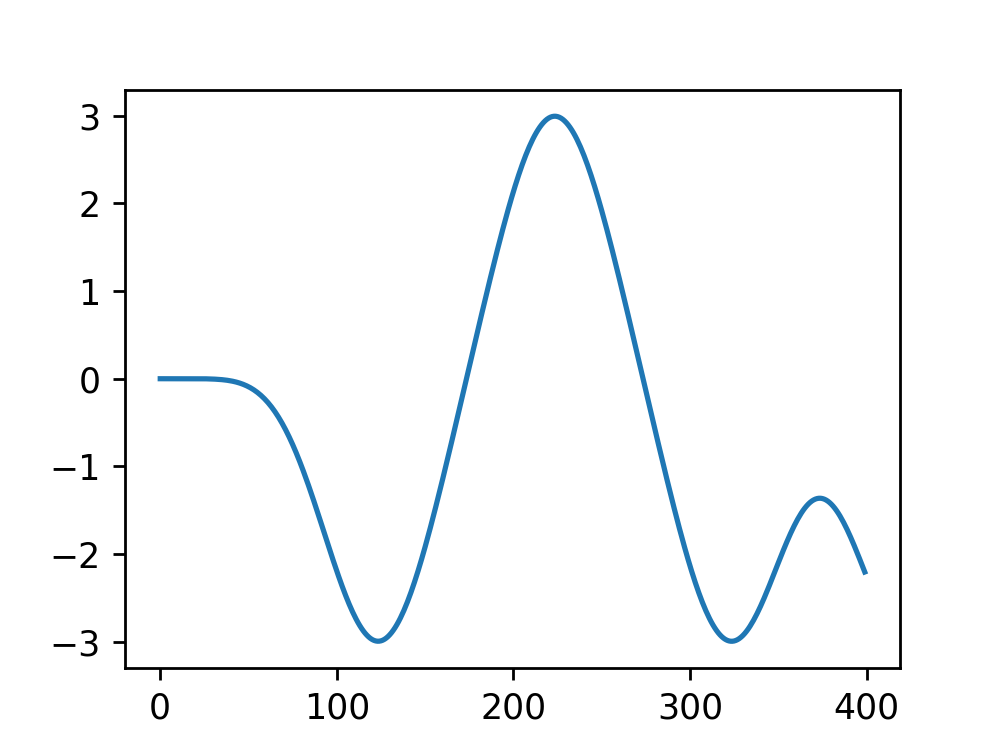

In [32]:
correlated = pulse_correlator(baseband, M)
# Filter delay of linear phase filter is (taps-1)/2 = 24.5, round to 25
# Peak for correlate(pulse, pulse) is at M - 1 = 99
# First best sampling time = 99 + 25 = 124
# After that, sample every M = 100 samples
plt.plot(correlated[:4*M]);
# The plot below corresponds to the first three symbols [-3, 3, -3]

In [38]:
# Check group delay of linear phase filter explicitly
# See explanations here:
# https://dsp.stackexchange.com/questions/18435/group-delay-of-the-fir-filter
# https://www.mathworks.com/help/signal/ug/compensate-for-the-delay-introduced-by-an-fir-filter.html
taps = 50
Fs = 1/Ts
band_edges = np.array([0, 0.1, 0.2, 1])*(Fs//2) # Cutoff at 0.2*Fs/2
damps = [1, 0]
b = signal.remez(taps, band_edges, damps, fs=Fs)
w, gd = signal.group_delay((b, 1))
gd[:10]

array([24.5, 24.5, 24.5, 24.5, 24.5, 24.5, 24.5, 24.5, 24.5, 24.5])

In [ ]:
plt.close('all')